Now we load the model we trained in the last step. If you're using a GPU, this will start it up, which can takeup to **10 seconds**. If you're using a GPU with less memory like the 750M, make sure to close the previous notebook or you will run out of GPU memory.

In [1]:
import keras
from keras.models import model_from_json
model = model_from_json(open('model.json').read())
model.load_weights('weights.h5')

Using TensorFlow backend.


Let's test the model by defining a function that evaluates a single image and prints a corresponding indicator.

In [2]:
import numpy as np
def print_indicator(data, model, class_names, bar_width=50):
    probabilities = model.predict(np.array([data]))[0]
    print(probabilities)
    left_count = int(probabilities[1] * bar_width)
    right_count = bar_width - left_count
    left_side = '-' * left_count
    right_side = '-' * right_count
    print class_names[0], left_side + '###' + right_side, class_names[1]

We'll test it on one image from our data set.

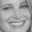

[ 0.0868205   0.91317958]
Neutral ---------------------------------------------###----- Smiling


In [3]:
from utils import show_array
X = np.load('X.npy')
class_names = ['Neutral', 'Smiling']
img = X[-7]
show_array(255 * img)
print_indicator(img, model, class_names)

Now let's try it in realtime. One way to do this is to use OpenCV for video capture, then crop and resize every frame and process it.

In [ ]:
from IPython.display import clear_output
from utils import crop_and_resize
import cv2

video_capture = cv2.VideoCapture(0)
try:
    while True:
        ret, frame = video_capture.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        data = crop_and_resize(gray, 32, zoom=0.6)
#         show_array(data)
        data = data.astype(np.float) / 255.
        print_indicator(data, model, class_names)
        clear_output(wait=True)
except KeyboardInterrupt:
    pass
video_capture.release()

Alternatively, we can wait for video input with zmq, processing one frame every `display_rate` seconds. This should be running at the same time as the `ZMQVideoInput` app.

In [ ]:
from IPython.display import clear_output
from time import time
import zmq

display_rate = 1./10
addr = 'tcp://localhost:14000'

img_rows, img_cols = model.input_shape[1:]

context = zmq.Context()
subs = context.socket(zmq.SUB)
subs.setsockopt(zmq.SUBSCRIBE, '')
subs.connect(addr)
start = time()
previous = 0
try:
    while True:
        raw = subs.recv()
        duration = (time() - start) % display_rate
        if duration < previous:
            data = np.fromstring(raw, dtype=np.uint8).reshape(img_rows, img_cols)
#             show_array(data) # uncomment this to see the image
            data = data.astype(np.float) / 255.
            print_indicator(data, model, class_names)
            clear_output(wait=True)
        previous = duration
except KeyboardInterrupt:
    pass